*******
<div style="padding:20px;color:black;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#bdd6f5;overflow:hidden;font-weight:500">Prédiction de la consommation d'énergie des bâtiments publiques à Seattle</div>

*******

### Tables des matières<a class="anchor" id="retour"></a>

[Présentation de la partie 2](#Présentation)


* [Partie 2 🛠 Machine Learning (Régression) ](#Partie_2)

    * [2.1 Régression lineaire comme baseline](#Section_2.1)
    * [2.2 Régression linéaire sur données centrées réduite](#Section_2.2)
    * [2.3 Régression Ridge ](#Section_2.3)
    * [2.4 Régression LASSO ](#Section_2.4)
    * [2.5 Régression sur les 3 premières composantes principales ](#Section_2.5)
    * [2.6 Régression linéaire sur données en log ](#Section_2.6)
    * [2.7 Gradient Boosting regressor sur données en log (Scikit Learn) ](#Section_2.7)
    * [2.8 XGBoost](#Section_2.8)
    * [2.9 XGBoost (avec ENERGYSTARScore)](#Section_2.9)


[Conclusion partie 2](#Conclusion)

[Références](#Références)

In [1]:
# Importation des librairies

import pandas as pd
import numpy as np

# Lib pour réaliser des graphiques
import matplotlib.pyplot as plt
import seaborn as sns

# Lib pour mesurer le temps execution
import time


# Lib pour regression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

# Lib pour séparer les données en 2 set
from sklearn.model_selection import train_test_split

# Lib pour travailler sur les données CR
from sklearn import preprocessing
from sklearn.decomposition import PCA
import sklearn.decomposition

# Lib pour réccupérer le RMSE
from sklearn.metrics import mean_squared_error

# Lib pour l'imputation des données manquantes (algorythme des KNN)
from sklearn.impute import KNNImputer

# Lib pour le passage en log
import math

# Lib pour le gridsearch et les métriques
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics

****
<div style="padding:20px;color:black;margin:0;font-size:200%;display:fill;border-radius:5px;background-color:#e9f1fc;overflow:hidden;font-weight:500">Partie 2 🛠 Machine Learning (Régression)</div>
<a class="anchor" id="Partie_2"></a>

****

## Présentation partie 2
<a class="anchor" id="Partie_2"></a>

In [2]:
# Importation des données
df = pd.read_csv("df.csv",sep=";")
df_float = pd.read_csv("df_float.csv",sep=";")
df_objet = pd.read_csv("df_objet.csv",sep=";")

In [3]:
# Suppression des colonnes inutiles
df_float = df_float.drop(columns=["Unnamed: 0"])
df_objet = df_objet.drop(columns=["Unnamed: 0"])
df = df.drop(columns=["Unnamed: 0"])

In [4]:
target=df[["SiteEnergyUse(kBtu)"]]

### Création de fonctions

In [5]:
# Création d'une fonction qui renvoit le RMSE

def rmse(X_test,pred):
    MSE = mean_squared_error(y_test, pred.prediction)
    RMSE = math.sqrt(MSE)
    return print(RMSE)

In [6]:
# Création d'une fonction qui passe un df au log

def df_au_log(data_1):
    val = np.log(data_1.values)
    data_2 = pd.DataFrame(data=val,columns=data_1.columns,index=data_1.index)
    return data_2

In [7]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue

def coef_sort(model):
    coef = pd.DataFrame(data=model.coef_,columns=df_float.columns)
    coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
    coef["coeff_sort"] = coef["coeff"].abs()
    coef = coef.sort_values(by="coeff_sort",ascending=False)
    return coef

## 2.1) Régression linéaire comme baseline
<a class="anchor" id="Section_2.1"></a>

In [8]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float, target, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps = tps2 - tps1
print("Temps de calcul : ",temps,"ms")

Temps de calcul :  0.015621423721313477 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [9]:
print("R2 sur le set d'apprentissage: ",model.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5693600409060608 
 R2 sur le set de test:  0.6958262765038947


In [10]:
# Création d'un DF des valeurs prédites de X_test
pred = model.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])
pred

# Affichage du RMSE
rmse(X_test,pred)

19108462.798491135


In [11]:
# Création d'un DF composée de la target la prédiction et les résidus

y_model = y_test.merge(df_float["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_model = pd.DataFrame(y_model).reset_index()
y_model = y_model.drop(columns=["index"])
pred = pd.concat([y_model[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,1.053291e+06,56340,2.148273e+06,-1.094982e+06
1,6.697878e+05,30796,3.652226e+05,3.045652e+05
2,4.885154e+05,23177,-6.415847e+05,1.130100e+06
3,2.871325e+05,25000,1.548701e+06,-1.261568e+06
4,1.678459e+06,20539,1.124384e+06,5.540748e+05
...,...,...,...,...
1000,1.388812e+06,55842,2.390942e+06,-1.002130e+06
1001,1.746374e+07,526423,3.500226e+07,-1.753852e+07
1002,3.696785e+06,40329,8.627284e+05,2.834056e+06
1003,1.004643e+07,220018,8.643235e+06,1.403199e+06


<Figure size 300x300 with 0 Axes>

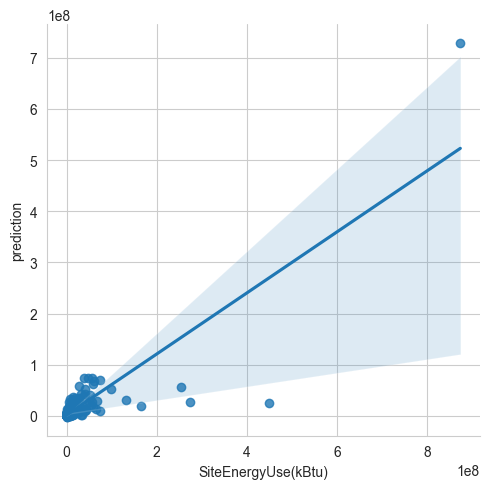

In [12]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [13]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model)
coef

,coeff,coeff_sort
NumberofBuildings,2.113255e+06,2.113255e+06
tx_gaz,1.183079e+06,1.183079e+06
BulType,5.171212e+05,5.171212e+05
NumberofFloors,-1.925828e+05,1.925828e+05
Council,-8.776758e+04,8.776758e+04
PPT,-5.620483e+04,5.620483e+04
Zip,-1.257344e+04,1.257344e+04
years,1.128130e+04,1.128130e+04
Voisin,-7.672696e+03,7.672696e+03
ThirdLargestPropertyUseTypeGFA,-7.145198e+01,7.145198e+01


Text(0.5, 1.0, 'Coefficients de regression')

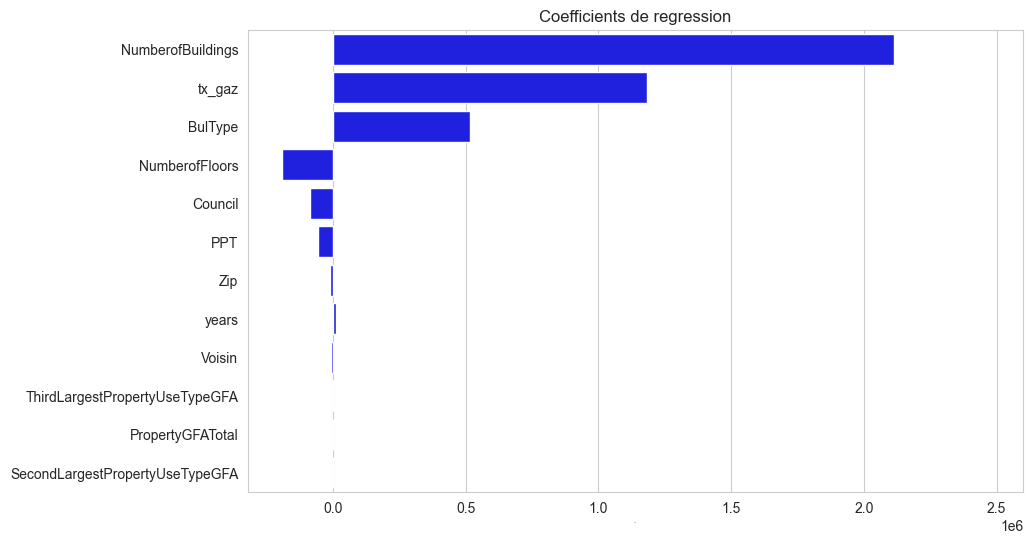

In [14]:
# Bar Plot des coeff

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-320_000, 2_600_000)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.2) Régression linéaire sur données centrées réduites
<a class="anchor" id="Section_2.2"></a>

Le modèle n'a pas l'air capable de prédire les 10 plus grandes valeur de la target.
Nous ne les conservons pas pour vérifier si le modèle est plus performant.
De plus nous travaillons dans cette partie sur les données centrées réduites

In [15]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

df_cr = pd.concat([target,df_float],axis=1)
df_cr = df_cr[df_cr["SiteEnergyUse(kBtu)"]<200_000_000]

df_float = df_cr.drop(columns=["SiteEnergyUse(kBtu)"])
target = df_cr[["SiteEnergyUse(kBtu)"]]


# Données centrées réduite sur toute la table entière

std_scale = preprocessing.StandardScaler().fit(df_float)
df_float_cr = std_scale.transform(df_float)

std_scale = preprocessing.StandardScaler().fit(target)
target_cr =  std_scale.transform(target)

# Permet d'avoir en output du modèle un DF
target_cr = pd.DataFrame(data=target_cr,columns=["SiteEnergyUse(kBtu)"],index=target.index)
df_float_cr = pd.DataFrame(data=df_float_cr,columns=df_float.columns,index=df_float.index)

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_cr = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_cr = tps2 - tps1
print("Temps de calcul : ",temps_cr,"ms")

Temps de calcul :  0.0 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [16]:
print("R2 sur le set d'apprentissage: ",model_cr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_cr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6133823365582051 
 R2 sur le set de test:  0.4423400348247515


In [17]:
# Création d'un DF des valeurs prédites de X_test
pred = model_cr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8565529123665856


In [18]:
# Création d'un DF composée de la target la prédiction et les résidus

y_cr = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_cr = pd.DataFrame(y_cr).reset_index()
y_cr = y_cr.drop(columns=["index"])
pred = pd.concat([y_cr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred


,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.395761,-0.021381
1,-0.428199,-0.483138,-0.390198,-0.038000
2,-0.260279,-0.307297,-0.165090,-0.095188
3,-0.326544,-0.243394,-0.092842,-0.233701
4,-0.318308,-0.222790,-0.058591,-0.259717
...,...,...,...,...
998,-0.358892,-0.441438,-0.429153,0.070262
999,0.136396,-0.415501,-0.347362,0.483758
1000,-0.340402,-0.267084,-0.159152,-0.181249
1001,0.003858,0.173982,0.090551,-0.086692


<Figure size 300x300 with 0 Axes>

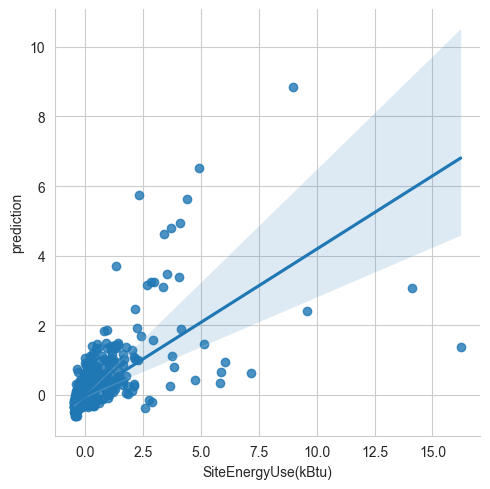

In [19]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [20]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_cr)
coef

,coeff,coeff_sort
PropertyGFATotal,0.702178,0.702178
NumberofBuildings,0.104424,0.104424
tx_gaz,0.052060,0.052060
BulType,0.038679,0.038679
Zip,-0.024395,0.024395
ThirdLargestPropertyUseTypeGFA,0.022351,0.022351
years,0.020033,0.020033
NumberofFloors,-0.014563,0.014563
Council,0.010278,0.010278
Voisin,-0.009713,0.009713


Text(0.5, 1.0, 'Coefficients de regression')

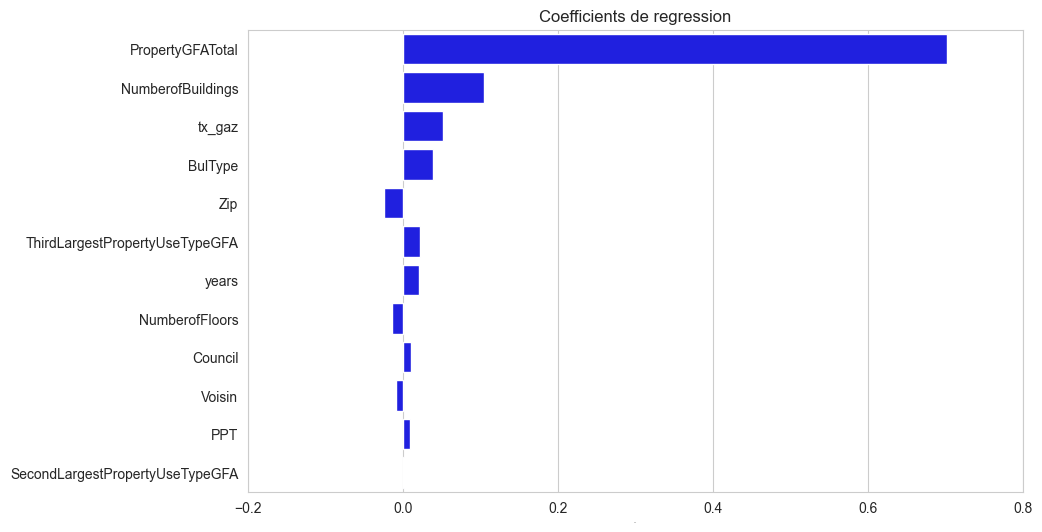

In [21]:
# Graphique des coeff
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.3) Régression Ridge
<a class="anchor" id="Section_2.3"></a>

Regression Ridge sur les données centrées réduites.
Utilisation d'un gridsearch afin de tester plusieurs hyperparamètre

In [22]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr, test_size=0.3, random_state=0)

In [23]:
# Modèle RIDGE

tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_ridge = GridSearchCV( Ridge(),
                            param_grid,
                            cv=10,
                            scoring=score )

model_ridge.fit(X_train,y_train)

tps2 = time.time()
temps_ridge = tps2 - tps1
print("Temps de calcul : ",temps_ridge,"ms")

Temps de calcul :  1.243577003479004 ms


In [24]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_ridge.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 100}


In [25]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_ridge.cv_results_['mean_test_score'], # score moyen
        model_ridge.cv_results_['std_test_score'],  # écart-type du score
        model_ridge.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                    mean,
                                                    std*2,
                                                    params ) )

Résultats de la validation croisée :
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.2}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.4}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.6}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.8}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 0.9}
mean_test_score = 0.593 (+/-0.179) for {'alpha': 2}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 5}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 9}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 10}
mean_test_score = 0.594 (+/-0.179) for {'alpha': 11}
mean_test_score = 0.594 (+/-0.178) for {'alpha': 12}
mean_test_score = 0.596 (+/-0.178) for {'alpha': 50}
mean_test_score = 0.596 (+/-0.178) for {'alpha': 100}


In [26]:
model_ridge.best_estimator_

Ridge(alpha=100)

In [27]:
reg_ridge= Ridge(alpha=0.2)
reg_ridge.fit(X_train,y_train)

Ridge(alpha=0.2)

In [28]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(reg_ridge)
coef

,coeff,coeff_sort
PropertyGFATotal,0.702001,0.702001
NumberofBuildings,0.104434,0.104434
tx_gaz,0.052059,0.052059
BulType,0.038692,0.038692
Zip,-0.024391,0.024391
ThirdLargestPropertyUseTypeGFA,0.022367,0.022367
years,0.020026,0.020026
NumberofFloors,-0.014492,0.014492
Council,0.010272,0.010272
Voisin,-0.009714,0.009714


Text(0.5, 1.0, 'Coefficients de regression')

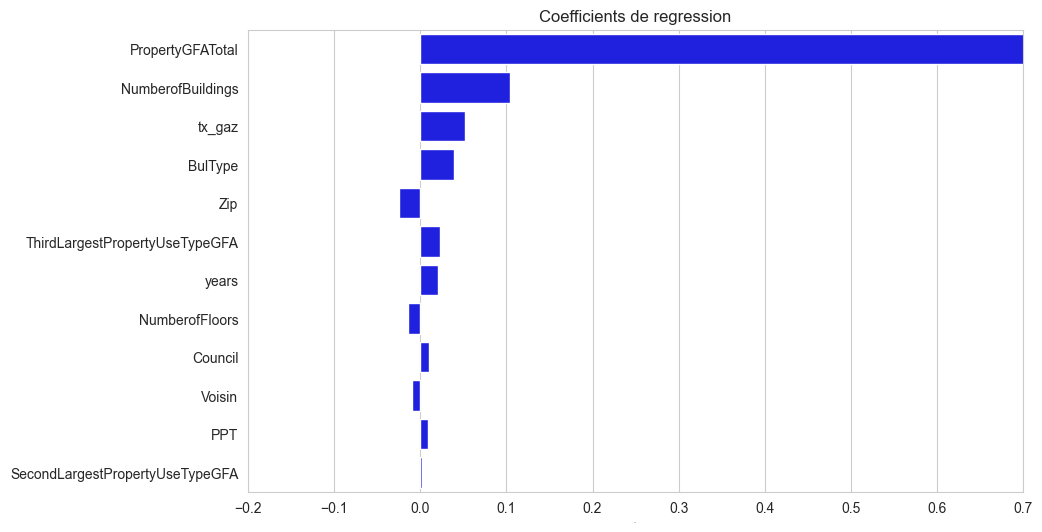

In [29]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2,0.7)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [30]:
print("R2 sur le set d'apprentissage: ",model_ridge.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_ridge.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6111879999181697 
 R2 sur le set de test:  0.4390895149251338


In [31]:
# Création d'un DF des valeurs prédites de X_test
pred = model_ridge.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8590456471913838


In [32]:
# Création d'un DF composée de la target la prédiction et les résidus

y_ridge = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_ridge = pd.DataFrame(y_ridge).reset_index()
y_ridge=y_ridge.drop(columns=["index"])
pred = pd.concat([y_ridge[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.371624,-0.045517
1,-0.428199,-0.483138,-0.381582,-0.046616
2,-0.260279,-0.307297,-0.168351,-0.091928
3,-0.326544,-0.243394,-0.087710,-0.238834
4,-0.318308,-0.222790,-0.070087,-0.248222
...,...,...,...,...
998,-0.358892,-0.441438,-0.416730,0.057839
999,0.136396,-0.415501,-0.337001,0.473397
1000,-0.340402,-0.267084,-0.161275,-0.179126
1001,0.003858,0.173982,0.114327,-0.110469


<Figure size 300x300 with 0 Axes>

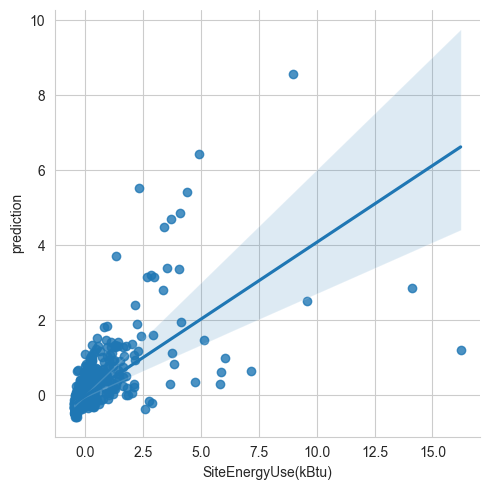

In [33]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

La régression Ridge n'a pas amélioré le pouvoir prédictif du modèle

## 2.4) Régression LASSO
<a class="anchor" id="Section_2.4"></a>

In [34]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_cr, target_cr,
                                                    test_size=0.3, random_state=0)

In [35]:
# Modèle LASSO
tps1 = time.time()

score="r2"
param_grid = { "alpha":[0.1,0.2,0.4,0.6,0.8,0.9,2,5,9,10,11,12,50,100]}

model_lasso = GridSearchCV( Lasso(),
                      param_grid,
                      cv=10,
                      scoring=score)

model_lasso.fit(X_train,y_train)

tps2 = time.time()
temps_lasso = tps2 - tps1
print("Temps de calcul : ",temps_lasso,"ms")

Temps de calcul :  1.1894898414611816 ms


In [36]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [37]:
# Afficher les performances correspondantes

result = 'mean_test_score'
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_lasso.cv_results_['mean_test_score'], # score moyen
        model_lasso.cv_results_['std_test_score'],  # écart-type du score
        model_lasso.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) pour {}".format( result,
                                                     mean,
                                                     std*2,
                                                     params) )

Résultats de la validation croisée :
mean_test_score = 0.598 (+/-0.213) pour {'alpha': 0.1}
mean_test_score = 0.569 (+/-0.232) pour {'alpha': 0.2}
mean_test_score = 0.430 (+/-0.201) pour {'alpha': 0.4}
mean_test_score = 0.186 (+/-0.093) pour {'alpha': 0.6}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.8}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 0.9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 2}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 5}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 9}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 10}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 11}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 12}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 50}
mean_test_score = -0.004 (+/-0.009) pour {'alpha': 100}


In [38]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_lasso.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [39]:
# Création d'un DF des valeurs prédites de X_test
pred = model_lasso.predict(X_test)
pred = pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.8860937031542888


In [40]:
print("R2 sur le set d'apprentissage: ",model_lasso.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_lasso.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.5854786745764325 
 R2 sur le set de test:  0.4032115961102126


In [41]:
reg_lasso = Lasso(alpha=0.2)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.2)

In [42]:
# Création d'un DF composée de la target la prédiction et les résidus

y_lasso = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_lasso = pd.DataFrame(y_lasso).reset_index()
y_lasso=y_lasso.drop(columns=["index"])
pred = pd.concat([y_lasso[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.296167,-0.120974
1,-0.428199,-0.483138,-0.312505,-0.115693
2,-0.260279,-0.307297,-0.204480,-0.055799
3,-0.326544,-0.243394,-0.165222,-0.161322
4,-0.318308,-0.222790,-0.152564,-0.165744
...,...,...,...,...
998,-0.358892,-0.441438,-0.286887,-0.072004
999,0.136396,-0.415501,-0.270953,0.407349
1000,-0.340402,-0.267084,-0.179775,-0.160626
1001,0.003858,0.173982,0.091187,-0.087329


<Figure size 300x300 with 0 Axes>

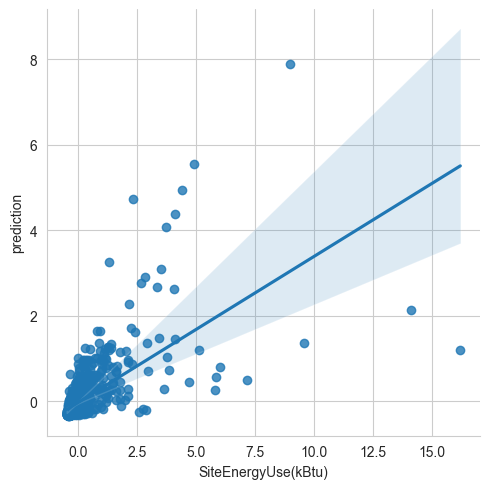

In [43]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [44]:
# Création d'un DF composé des coefficients

coef = pd.DataFrame(data=reg_lasso.coef_, columns = ["coeff"],index=df_float_cr.columns)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.515771,0.515771
years,0.000000,0.000000
NumberofFloors,0.000000,0.000000
NumberofBuildings,0.000000,0.000000
SecondLargestPropertyUseTypeGFA,0.000000,0.000000
ThirdLargestPropertyUseTypeGFA,0.000000,0.000000
tx_gaz,0.000000,0.000000
BulType,0.000000,0.000000
PPT,0.000000,0.000000
Zip,-0.000000,0.000000


Text(0.5, 1.0, 'Coefficients de regression')

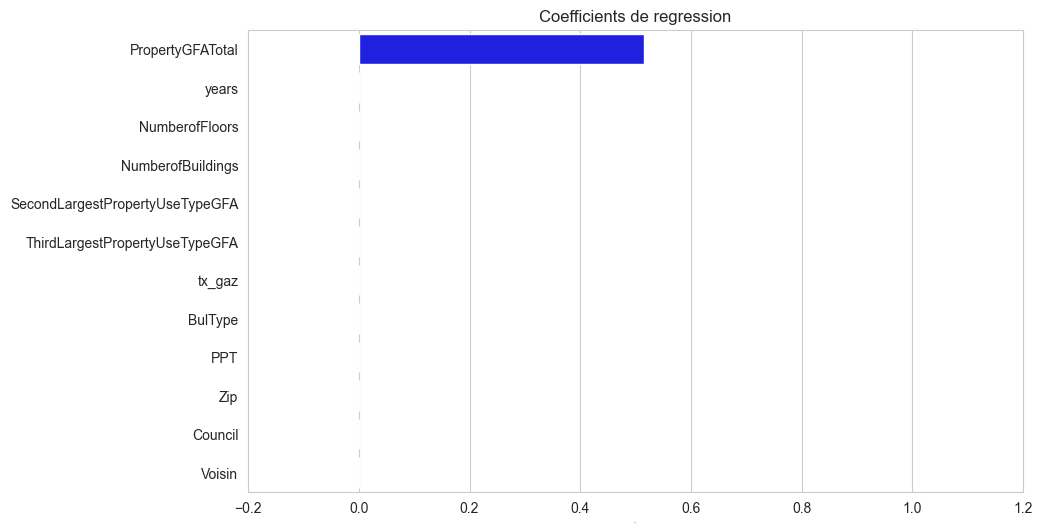

In [45]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

La régression LASSO montre toute son utilité:
- une seule variable permet d'expliquer le modèle
- la pénalité est efficace

## 2.5) Regression sur les 3 premieres composantes principales
<a class="anchor" id="Section_2.5"></a>

In [46]:
liste_r2=[]
liste_var=[]

for i in range(1,12):
    pca = PCA(n_components=i)
    pca.fit(df_float_cr)
    df_pca = pca.fit_transform(df_float_cr)

    X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

    model_pca = LinearRegression().fit(X_train, y_train)

    liste_r2.append(model_pca.score(X_test, y_test))
    liste_var.append(pca.explained_variance_ratio_.sum())

print(liste_r2,"\n",liste_var)

[0.2996642372274434, 0.31568391992396827, 0.3325683616347175, 0.37347464703184174, 0.37307273773263594, 0.37348640761774676, 0.3744802159375783, 0.3809540929050528, 0.39077420951639086, 0.3936033266368969, 0.4002528940075921] 
 [0.23608107931142033, 0.36537907492354105, 0.4823143689024747, 0.5702200108058837, 0.6505128508816505, 0.7216288750871956, 0.7855373477641687, 0.8484477630462954, 0.9011737254122367, 0.9490873286743191, 0.9834215643423136]


In [47]:
pca = PCA(n_components=3)
pca.fit(df_float_cr)

PCA(n_components=3)

In [48]:
pca.explained_variance_ratio_.sum()

0.48231436890247514

In [49]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes
df_pca = pca.fit_transform(df_float_cr)

In [50]:
# Création d'un DF ne contenant plus les 5 valeurs les plus grandes

# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_pca, target_cr,
                                                    test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_pca = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_pca = tps2 - tps1
print("Temps de calcul : ",temps_pca,"ms")

Temps de calcul :  0.01561594009399414 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [51]:
print("R2 sur le set d'apprentissage: ",model_pca.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_pca.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.4794231493958273 
 R2 sur le set de test:  0.3325683616347175


In [52]:
# Création d'un DF des valeurs prédites de X_test
pred = model_pca.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.9370717757585073


In [53]:
# Création d'un DF composée de la target la prédiction et les résidus

y_pca = y_test.merge(df_float_cr["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_pca = pd.DataFrame(y_pca).reset_index()
y_pca = y_pca.drop(columns=["index"])
pred = pd.concat([y_pca[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"] = pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,-0.417141,-0.456544,-0.185236,-0.231906
1,-0.428199,-0.483138,-0.353471,-0.074727
2,-0.260279,-0.307297,-0.387634,0.127355
3,-0.326544,-0.243394,0.187275,-0.513818
4,-0.318308,-0.222790,-0.237553,-0.080755
...,...,...,...,...
998,-0.358892,-0.441438,-0.499575,0.140683
999,0.136396,-0.415501,-0.146091,0.282487
1000,-0.340402,-0.267084,-0.361043,0.020642
1001,0.003858,0.173982,0.364788,-0.360930


<Figure size 300x300 with 0 Axes>

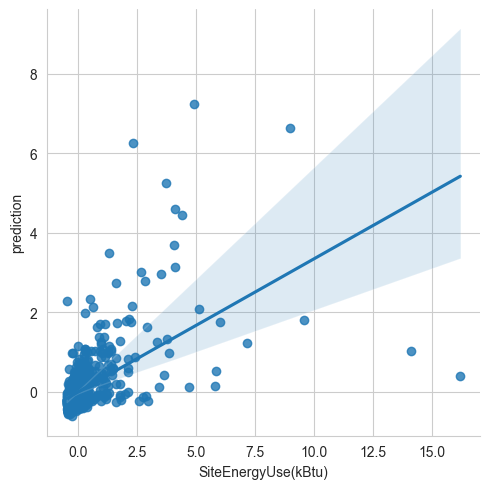

In [54]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [55]:
# Création d'une fonction composé des coeff de la regression triés par ordre en valeur absolue
df_pca = pd.DataFrame(data=df_pca,columns=["comp_1","comp_2","comp_3"])
coef = pd.DataFrame(data=model_pca.coef_,columns=df_pca.columns)
coef = pd.DataFrame(data=coef.transpose().values,columns=["coeff"],
                        index=coef.transpose().index)
coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
comp_1,0.366005,0.366005
comp_2,0.132282,0.132282
comp_3,0.106732,0.106732


Text(0.5, 1.0, 'Coefficients de regression')

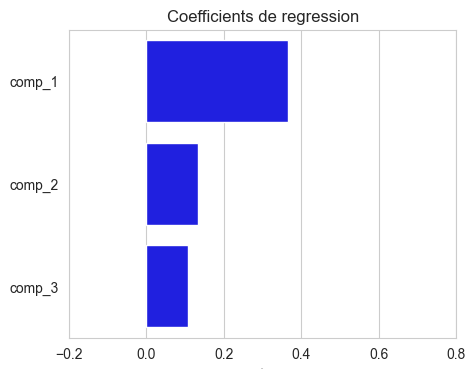

In [56]:
# Graphique des coeff

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlim(-0.2, 0.8)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.6) Régression sur le log des données
<a class="anchor" id="Section_2.6"></a>

In [57]:
# Transformation des DF en log

df_float[df_float==0]=1
df_float_log = df_au_log(df_float)

target[target==0]=1
target_log = df_au_log(target)

C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1
C:\Users\fbbou\AppData\Local\Temp\ipykernel_5728\277867087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target[target==0]=1


In [58]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log, test_size=0.3, random_state=0)

# Régression linéaire
tps1 = time.time()
model_log = LinearRegression().fit(X_train, y_train)
tps2 = time.time()
temps_log = tps2 - tps1
print("Temps de calcul : ",temps_log,"ms")

Temps de calcul :  0.015654563903808594 ms


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [59]:
print("R2 sur le set d'apprentissage: ",model_log.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_log.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.6496880741451658 
 R2 sur le set de test:  0.6568337597828426


In [60]:
# Création d'un DF des valeurs prédites de X_test
pred = model_log.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6748737775913579


In [61]:
# Création d'un DF composée de la target la prédiction et les résidus

y_log = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_log = pd.DataFrame(y_log).reset_index()
y_log=y_log.drop(columns=["index"])
pred = pd.concat([y_log[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.677154,-0.333047
1,13.153030,9.945157,13.556162,-0.403131
2,14.587529,10.742336,14.235388,0.352141
3,14.229982,10.924373,14.906539,-0.676557
4,14.282022,10.976645,14.717206,-0.435184
...,...,...,...,...
998,13.994488,10.199138,13.666889,0.327600
999,15.616972,10.329735,13.962551,1.654421
1000,14.135795,10.860690,14.445656,-0.309861
1001,15.375191,11.660112,15.487429,-0.112238


<Figure size 300x300 with 0 Axes>

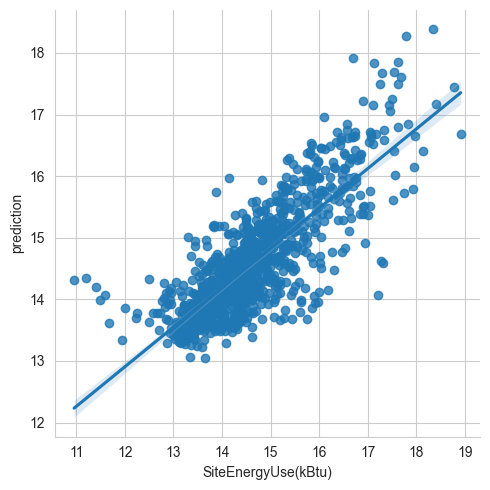

In [62]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [63]:
# Création d'un DF composé des coeff de la regression
coef = coef_sort(model_log)
coef

,coeff,coeff_sort
PropertyGFATotal,1.016554,1.016554
BulType,0.296566,0.296566
NumberofBuildings,0.216336,0.216336
Zip,-0.076806,0.076806
years,0.073846,0.073846
tx_gaz,-0.060010,0.060010
Council,0.051047,0.051047
Voisin,-0.039783,0.039783
PPT,-0.038100,0.038100
NumberofFloors,-0.022349,0.022349


Text(0.5, 1.0, 'Coefficients de regression')

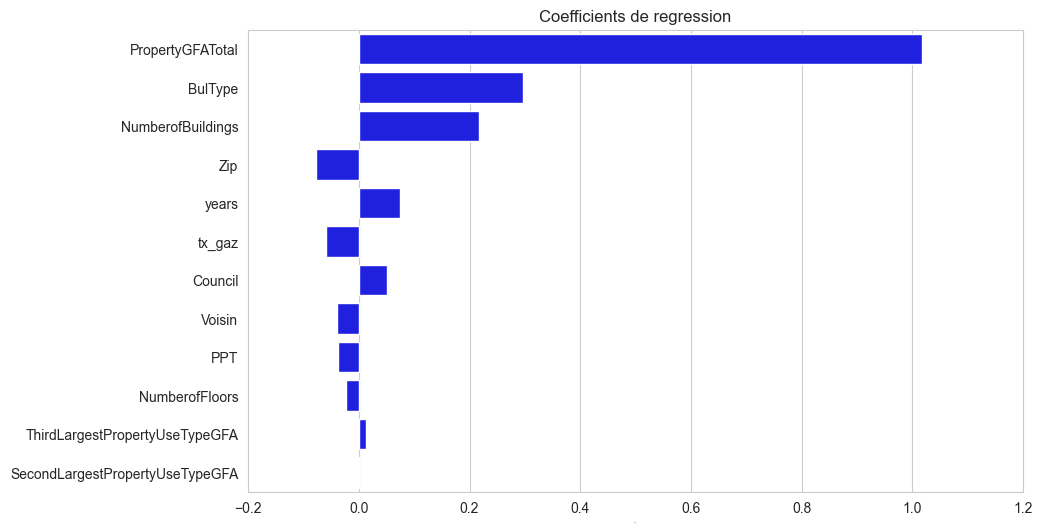

In [64]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.7) Gradient Boosting Regressor sur données en log
<a class="anchor" id="Section_2.7"></a>

In [65]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [66]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
param_grid = { "n_estimators":[50,100,200],
               "max_depth":[2,3,5],
               "alpha":[0.2,0.5,0.9]}

model_gbr = GridSearchCV( GradientBoostingRegressor(random_state=0),
                          param_grid,
                          cv = 10,
                          scoring = score)

model_gbr.fit(X_train,y_train)

tps2 = time.time()
temps_gbr = tps2 - tps1
print("Temps de calcul : ",temps_gbr,"ms")

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was pass

Temps de calcul :  185.25347328186035 ms


In [67]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_gbr.cv_results_['mean_test_score'], # score moyen
        model_gbr.cv_results_['std_test_score'],  # écart-type du score
        model_gbr.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.720 (+/-0.078) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.083) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 100}
mean_test_score = 0.759 (+/-0.087) for {'alpha': 0.2, 'max_depth': 2, 'n_estimators': 200}
mean_test_score = 0.741 (+/-0.085) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 50}
mean_test_score = 0.757 (+/-0.080) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 100}
mean_test_score = 0.769 (+/-0.077) for {'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}
mean_test_score = 0.748 (+/-0.085) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 50}
mean_test_score = 0.752 (+/-0.084) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 100}
mean_test_score = 0.750 (+/-0.082) for {'alpha': 0.2, 'max_depth': 5, 'n_estimators': 200}
mean_test_score = 0.720 (+/-0.078) for {'alpha': 0.5, 'max_depth': 2, 'n_estimators': 50}
mean_test_score = 0.747 (+/-0.083) for {'alpha': 0.5, 'ma

In [68]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_gbr.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.2, 'max_depth': 3, 'n_estimators': 200}


In [69]:
gbr = GradientBoostingRegressor( n_estimators=200,
                                max_depth=3,
                                alpha=0.2)
gbr.fit(X_train,y_train)

C:\Users\fbbou\PycharmProjects\O-C\Projet_4\venv\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.2, n_estimators=200)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [70]:
print("R2 sur le set d'apprentissage: ",model_gbr.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_gbr.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8595590297415839 
 R2 sur le set de test:  0.7757572192654065


In [71]:
# Création d'un DF des valeurs prédites de X_test
pred = gbr.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5570629805102751


In [72]:
# Création d'un DF composée de la target la prédiction et les résidus

y_bgr = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_bgr = pd.DataFrame(y_bgr).reset_index()
y_bgr = y_bgr.drop(columns=["index"])
pred = pd.concat([y_bgr[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.715423,-0.371316
1,13.153030,9.945157,13.448522,-0.295491
2,14.587529,10.742336,14.805579,-0.218051
3,14.229982,10.924373,14.257890,-0.027908
4,14.282022,10.976645,15.236201,-0.954178
...,...,...,...,...
664,14.679065,10.945529,14.889173,-0.210108
665,14.494171,11.547848,14.825878,-0.331707
666,13.895677,10.034296,14.064354,-0.168677
667,14.578931,10.651099,14.250319,0.328612


<Figure size 300x300 with 0 Axes>

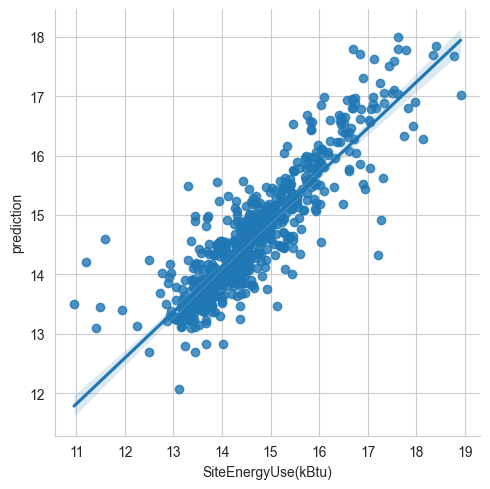

In [73]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

In [74]:
coef =pd.DataFrame(data=gbr.feature_importances_,index=df_float.columns,columns=["coeff"])

coef["coeff_sort"] = coef["coeff"].abs()
coef = coef.sort_values(by="coeff_sort",ascending=False)
coef

,coeff,coeff_sort
PropertyGFATotal,0.740079,0.740079
PPT,0.085136,0.085136
tx_gaz,0.076983,0.076983
BulType,0.042962,0.042962
years,0.017177,0.017177
NumberofFloors,0.008503,0.008503
SecondLargestPropertyUseTypeGFA,0.008184,0.008184
Zip,0.006807,0.006807
ThirdLargestPropertyUseTypeGFA,0.006569,0.006569
Voisin,0.003799,0.003799


Text(0.5, 1.0, 'Coefficients de regression')

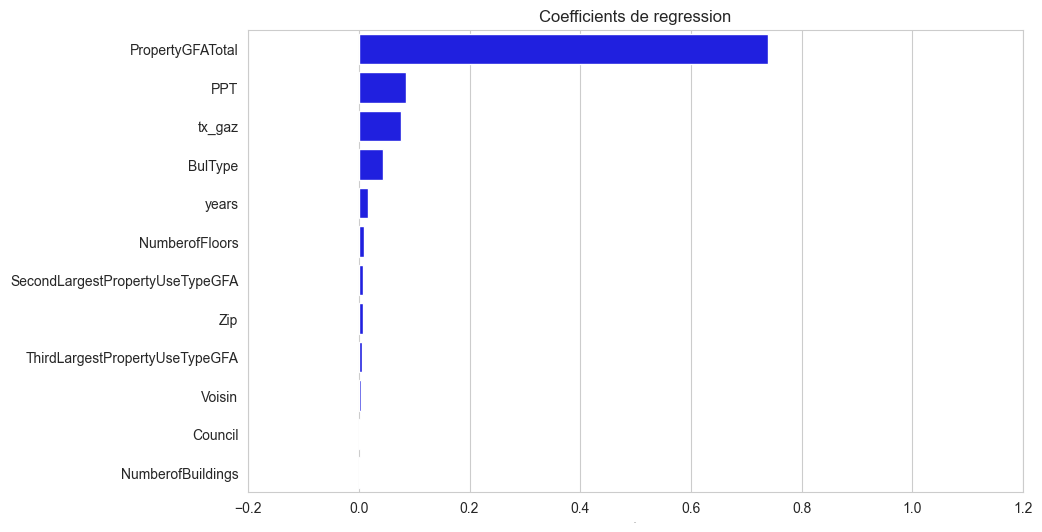

In [75]:
# Représentation graphique des coefficients

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(-0.2, 1.2)
ax.set_xlabel( "",size=0 )
sns.barplot(x =coef.coeff  , y =coef.index ,data = coef , color = 'b',orient='h')
plt.setp(ax.get_yticklabels(),fontsize = 10)
plt.title("Coefficients de regression")

## 2.8) XGBoost sur données en log
<a class="anchor" id="Section_2.8"></a>

In [76]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [77]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [2],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb = tps2 - tps1
print("Temps de calcul : ",temps_xgb,"s")

Temps de calcul :  10.154380083084106 s


In [78]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.349 (+/-0.041) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.364 (+/-0.051) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.368 (+/-0.054) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.733 (+/-0.047) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.744 (+/-0.044) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}
mean_test_score = 0.748 (+/-0.049) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [79]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2, 'objective': 'reg:squarederror'}


### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [80]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.8572409060358797 
 R2 sur le set de test:  0.7672519711062465


In [81]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[17:20:38] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 5, 'n_estimators': 100, 'n_jobs': 2,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

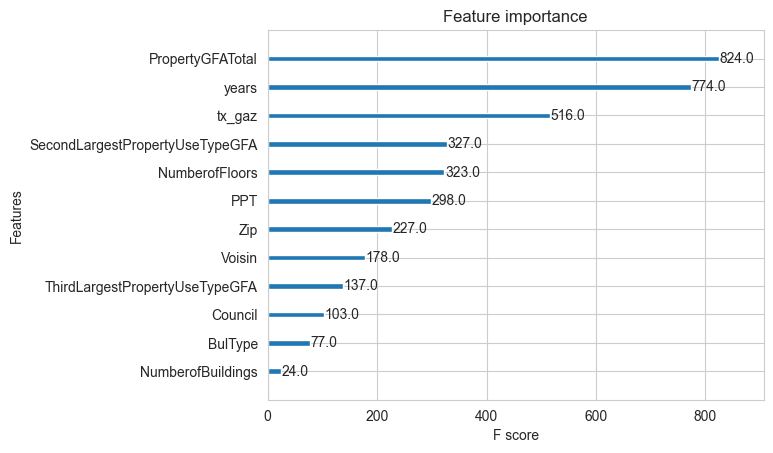

In [82]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

In [83]:
# Création d'un DF des valeurs prédites de X_test
pred = xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.6016111577452495


In [84]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xbg = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,right_index=True)
y_xbg = pd.DataFrame(y_xbg).reset_index()
y_xbg = y_xbg.drop(columns=["index"])
pred = pd.concat([y_xbg[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.114397,13.637609,-0.293502
1,13.153030,9.945157,13.462501,-0.309470
2,14.587529,10.742336,14.923277,-0.335748
3,14.229982,10.924373,14.191026,0.038956
4,14.282022,10.976645,15.181220,-0.899198
...,...,...,...,...
664,14.679065,10.945529,14.890182,-0.211117
665,14.494171,11.547848,14.889601,-0.395429
666,13.895677,10.034296,14.129717,-0.234040
667,14.578931,10.651099,14.619933,-0.041002


<Figure size 300x300 with 0 Axes>

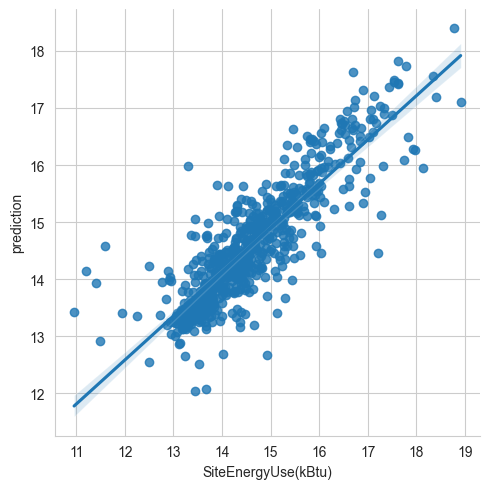

In [85]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (3,3))
sns.lmplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction")

## 2.9) Régression XGBoost avec la variable ENERGYSTARScore
<a class="anchor" id="Section_2.9"></a>

In [86]:
# On inclut la variable ENERGYscore ds le modèle
df_float["ENERGYSTARScore"]=df["ENERGYSTARScore"]
df_float_log = df_au_log(df_float)

In [87]:
# Imputation des données manquantes (ENERGYscore) par les KNN

imputer = KNNImputer(n_neighbors=5)

df_float_log = pd.DataFrame(data=imputer.fit_transform(df_float_log),
                            columns=df_float_log.columns)

In [88]:
# Création de quatre DF: train et test
X_train, X_test, y_train, y_test = train_test_split(df_float_log, target_log,
                                                    test_size=0.2, random_state=0)

In [89]:
# Construction du modèle gradient boosting regressor

tps1 = time.time() # Temps d'execution

score ="r2"
xgb = xgboost.XGBRegressor()
parameters = { "max_depth":[3,5,7],
               'objective':['reg:squarederror'],
               "booster" :["gbtree"],
               "n_estimators" : [100],
                "n_jobs" : [1],
               'learning_rate': [0.03, 0.05, 0.07]}

model_xgb = GridSearchCV( estimator=xgb,
                          param_grid= parameters,
                          cv = 5,
                          scoring = score
                          )

model_xgb.fit(X_train,y_train)

tps2 = time.time()
temps_xgb_E = tps2 - tps1
print("Temps de calcul : ",temps_xgb_E,"ms")

Temps de calcul :  12.316489219665527 ms


In [90]:
# Afficher les performances correspondantes

result = "mean_test_score"
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        model_xgb.cv_results_['mean_test_score'], # score moyen
        model_xgb.cv_results_['std_test_score'],  # écart-type du score
        model_xgb.cv_results_['params'] ):          # valeur de l'hyperparamètre

    print("{} = {:.3f} (+/-{:.03f}) for {}".format( result,
                                                   mean,
                                                   std*2,
                                                   params) )

Résultats de la validation croisée :
mean_test_score = 0.375 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.399 (+/-0.040) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.398 (+/-0.042) for {'booster': 'gbtree', 'learning_rate': 0.03, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.767 (+/-0.041) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.786 (+/-0.039) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}
mean_test_score = 0.790 (+/-0.030) for {'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'n_jobs

In [91]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model_xgb.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'booster': 'gbtree', 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1, 'objective': 'reg:squarederror'}


In [92]:
xgb = xgboost.XGBRegressor(parametre=model_xgb.best_params_)
xgb.fit(X_train,y_train)

[17:20:53] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "parametre" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1,
             parametre={'booster': 'gbtree', 'learning_rate': 0.07,
                        'max_depth': 7, 'n_estimators': 100, 'n_jobs': 1,
                        'objective': 'reg:squarederror'},
             predictor='auto', ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

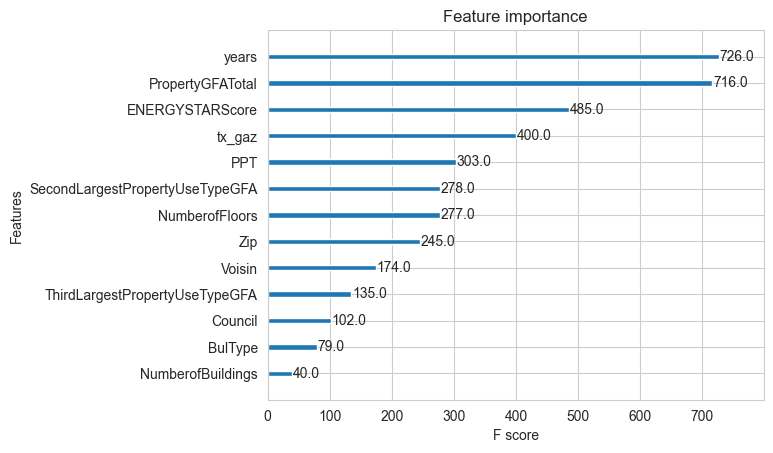

In [93]:
# Représentation graphique de l'importance de chaque variable
xgboost.plot_importance(xgb)

### Métriques R2 & RMSE
### Représentation graphique des coefficients et du pouvoir prédictif du modèle

In [94]:
print("R2 sur le set d'apprentissage: ",model_xgb.score(X_train, y_train),"\n",
    "R2 sur le set de test: ",model_xgb.score(X_test, y_test))

R2 sur le set d'apprentissage:  0.9403253669458614 
 R2 sur le set de test:  0.7881425343418933


In [95]:
# Création d'un DF des valeurs prédites de X_test
pred = model_xgb.predict(X_test)
pred=pd.DataFrame(pred,columns=["prediction"])

# Affichage du RMSE
rmse(X_test,pred)

0.5417705341876412


In [96]:
# Création d'un DF composée de la target la prédiction et les résidus

y_xgb_star = y_test.merge(df_float_log["PropertyGFATotal"],how="left",left_index=True,
                          right_index=True)
y_xgb_star = pd.DataFrame(y_xgb_star).reset_index()
y_xgb_star = y_xgb_star.drop(columns=["index"])
pred = pd.concat([y_xgb_star[["SiteEnergyUse(kBtu)","PropertyGFATotal"]],pred],axis=1)
pred["residus"]=pred["SiteEnergyUse(kBtu)"]-pred["prediction"]
pred

,SiteEnergyUse(kBtu),PropertyGFATotal,prediction,residus
0,13.344107,10.542099,13.704056,-0.359949
1,13.153030,10.249804,13.253844,-0.100814
2,14.587529,11.100496,14.730147,-0.142618
3,14.229982,11.021183,14.190002,0.039980
4,14.282022,11.099423,15.244688,-0.962666
...,...,...,...,...
664,14.679065,11.438116,14.872330,-0.193265
665,14.494171,10.007622,14.722744,-0.228573
666,13.895677,11.060212,13.885085,0.010592
667,14.578931,9.980449,14.438264,0.140668


<AxesSubplot: xlabel='SiteEnergyUse(kBtu)', ylabel='prediction'>

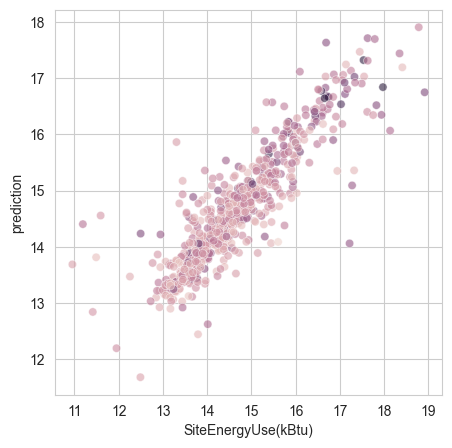

In [97]:
# Graphique de la target et de la prédiction
plt.figure(figsize = (5,5))
sns.scatterplot(data=pred, x="SiteEnergyUse(kBtu)", y="prediction",hue="PropertyGFATotal",
                legend=False,alpha=0.6)

## Conclusion partie 2
<a class="anchor" id="Conclusion"></a>

# 📄 References<a class="anchor" id="Références"></a>
- [Data Seattle](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
- [Librairie Pandas](https://pandas.pydata.org/docs/user_guide/index.html#)
- [Librairie scikit-learn](https://scikit-learn.org/stable/user_guide.html)
- [Librairie XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)